In [1]:
# List of modules that are not installed in the course
!pip install OpenPermID
!pip install geocoder

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Downloading all bonds ever owned in CSPP

In [3]:
from functions import downloadECBBonds

In [4]:
holdingsECB = downloadECBBonds.download_ECB_Bonds()

# ECB green bonds that are listed on Euronext stock exchange 

TODO: make 1 function in .py file

In [5]:
#reading data of green bonds listed on Euronext 
euronext_greenbonds = pd.read_excel("data/Euronext-Green-Bond-List.xlsx", header=0)
euronext_greenbonds

<ipython-input-5-5cab896166ca>:2: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  euronext_greenbonds = pd.read_excel("data/Euronext-Green-Bond-List.xlsx", header=0)


,Issuer,ISIN,Listing Date,Amount (million),Currency,Bond Type,Listing Venue
0,AB STENA METALL FINANS,NO0010823362,2018-09-03 00:00:00,800.0,SEK,Green Bond,Oslo
1,ABN AMRO BANK N.V.,XS1982037696,2019-04-15 00:00:00,750.0,EUR,Green Bond,Amsterdam
2,ABN AMRO BANK N.V.,XS1808739459,2018-04-18 00:00:00,750.0,EUR,Green Bond,Amsterdam
3,ABN AMRO BANK N.V.,XS1422841202,2016-05-31 00:00:00,500.0,EUR,Green Bond,Amsterdam
4,"ACCIONA FINANCIACIÓN FILIALES, S.A. UNIPERSONAL",XS2327979675,2021-04-07 00:00:00,62.0,RON,Green Bond,Dublin
...,...,...,...,...,...,...,...
432,VESTEDA FINANCE BV,XS2001183164,2019-05-24 00:00:00,500.0,EUR,Green Bond,Amsterdam
433,VILLE DE PARIS,FR00140007D0,2020-10-20 00:00:00,300.0,EUR,Green Bond,Paris
434,VILLE DE PARIS,FR0013054897,2015-11-18 00:00:00,300.0,EUR,Green Bond,Paris
435,VZ VENDOR FINANCING II B.V.,XS2272845798,2021-01-15 00:00:00,700.0,EUR,Green Bond,Dublin


In [6]:
#Getting the ISIN of the Euronext green bonds 
euronext_greenbond_isin = euronext_greenbonds["ISIN"]
euronext_greenbond_isin

0      NO0010823362
1      XS1982037696
2      XS1808739459
3      XS1422841202
4      XS2327979675
           ...     
432    XS2001183164
433    FR00140007D0
434    FR0013054897
435    XS2272845798
436    BE0002777580
Name: ISIN, Length: 437, dtype: object

In [7]:
#Comparing the ISINs of the ECB and Euronext green bonds and returning matches 
ecbgreenbonds = holdingsECB[(holdingsECB["ISIN"].isin(euronext_greenbond_isin))]
ecbgreenbonds

,ISIN,NCB,ISSUER,MATURITY DATE,COUPON RATE
51,XS1400167133,BE,Alliander N.V.,22/04/2026,0.875
289,XS1550149204,IT,ENEL Finance Intl N.V.,16/09/2024,1
338,FR0013170834,FR,Fonciere des Regions S.A.,20/05/2026,1.875
656,XS1241581096,BE,TenneT Holding BV,04/06/2027,1.75
657,XS1241581179,BE,TenneT Holding BV,04/06/2021,0.875
...,...,...,...,...,...
1796,XS2320453884,FI,UPM-Kymmene OYJ,22/03/2031,0.5
1813,FR0013426731,FR,Regie Autonome des Transports Parisiens (RATP),20/06/2029,0.35
1814,XS2324772453,IT,Ferrovie dello Stato Ital.SpA,25/03/2028,0.375
1818,FR0013447232,FR,Covivio S.A.,17/09/2031,1.125


TODO: calculate percentage green before and after 2020

# Read all the Eikon data

In [8]:
from functions import readEikonData
eikon_data_complete = readEikonData.get_eikon_data_complete()
eligible_complete = readEikonData.get_data_eligible_complete() # read all data from eligible universe

Compare how many bonds from the eligible universe the ECB bought.

In [9]:
overlap = eikon_data_complete[(eikon_data_complete["ISIN"].isin(eligible_complete["ISIN"]))]
print("the percentage of bonds bought by ECB in eligible universe that we have info on:    ", 
      overlap.shape[0]/eligible_complete.shape[0])

the percentage of bonds bought by ECB in eligible universe that we have info on:     0.16143170197224252


__More companies mapped in Eikon database (370 vs 339), but more industries mapped in PermID database (313 vs 158).__
TODO: Move this conclusion from the comparison between Eikon and PermID to a better place.

Read the dates

In [10]:
years_issuer_bought = readEikonData.get_dates_data_frame()

# Sector Analysis

## Get all sector data from PermID

In [11]:
from functions import permidSectors
sector_mappings = permidSectors.get_sector_mappings(holdingsECB)
sector_mappings.count()

d:\0Data_Analytics_PROJECT\functions\permidSectors.py:119: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  sector_mappings = pd.read_excel(parent+'\output\sector_mappings_data.xlsx', header=0)


Unnamed: 0                  370
ISSUER                      370
LEI                         367
CompanyName                 367
PermID                      367
hasPrimaryBusinessSector    360
hasPrimaryEconomicSector    360
hasPrimaryIndustryGroup     360
isIncorporatedIn            367
isDomiciledIn               367
dtype: int64

## Represent industries and sectors

Create a pie chart to represent the number of times an industry, sector or supersector is present in the data (multiple bonds for the same company are counted separately)

In [12]:
from functions import pieCharts

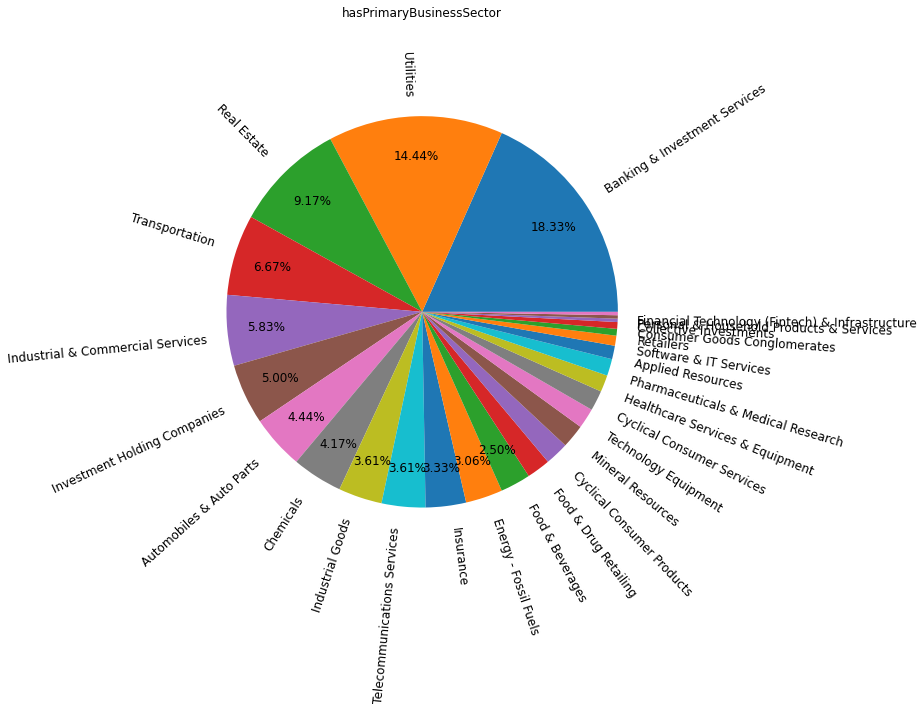

In [13]:
pieCharts.make_pie_chart('hasPrimaryBusinessSector', sector_mappings)

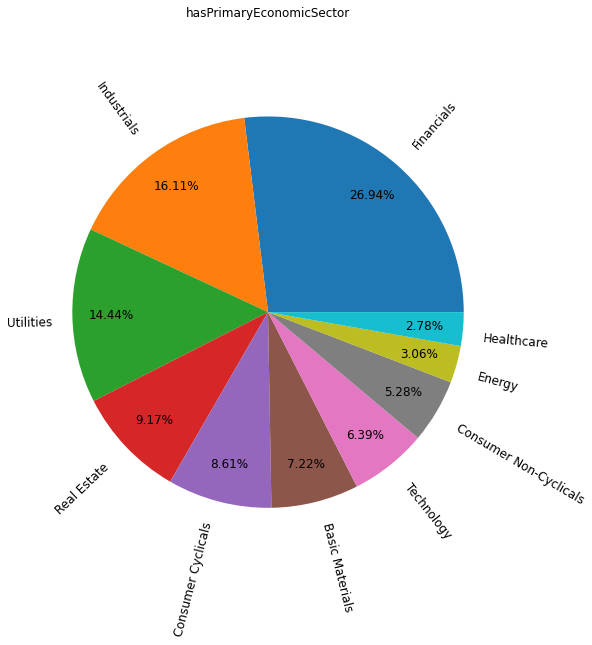

In [14]:
pieCharts.make_pie_chart('hasPrimaryEconomicSector', sector_mappings)

In [15]:
# make_pie_chart('hasPrimaryIndustryGroup') # TODO: Fix Error

## Which industries and sectors are green?

Map the dictionary with greenness of all PermID sectors with the ones in which ECB invested



In [16]:
from functions import sectors
sector_green_dict = sectors.get_sector_green_dict()

In [17]:
primary_business_sector = pieCharts.get_all_sectors("hasPrimaryBusinessSector", sector_mappings)
primary_business_sector = sectors.map_green_dict_to_data_frame(primary_business_sector)
print(primary_business_sector)

primary_economic_sector = pieCharts.get_all_sectors("hasPrimaryEconomicSector", sector_mappings)
primary_economic_sector = sectors.map_green_dict_to_data_frame(primary_economic_sector)
print(primary_economic_sector)

                                                 number green
hasPrimaryBusinessSector                                     
Banking & Investment Services                        66     0
Utilities                                            52     1
Real Estate                                          33     0
Transportation                                       24     1
Industrial & Commercial Services                     21     0
Investment Holding Companies                         18     0
Automobiles & Auto Parts                             16    -1
Chemicals                                            15    -1
Industrial Goods                                     13    -1
Telecommunications Services                          13     0
Insurance                                            12     0
Energy - Fossil Fuels                                11    -1
Food & Beverages                                      9     0
Food & Drug Retailing                                 7     0
Cyclical

TODO:
- Total Count for each sector overall and compare these sectors (we view as “bad”, like cement, oil&gas or with kaggle dataset(emission))
- Similar approach but per year → do we see a change in habit, total counts → differences in the sectors 
- For the sectors: make spaghetti plot with for each sector the percentage invested in every year (in app: select which sectors you want)
    - Include in app (can view all, and have “buttons” to choose what to show) 

In [18]:
sector_mappings_with_years = sectors.get_sector_mappings_with_years(sector_mappings, years_issuer_bought)
print(sector_mappings_with_years)

     Unnamed: 0                       ISSUER                   LEI  \
0             0           2i Rete Gas S.p.A.  549300RV0WBR05UTDI91   
1             1                   A2A S.p.A.  81560076E3944316DB24   
2             2             ABB Finance B.V.  5493004JXXFB454B6L79   
3             3  Abertis Infraestructuras SA  549300GKFVWI02JQ5332   
4             4                  ACEA S.p.A.  549300Q3448N041CTH56   
..          ...                          ...                   ...   
365         365                   Vonovia SE  5299005A2ZEP6AP7KM81   
366         366    Vienna Insurance Group AG  549300JCRU23I1THU176   
367         367            Vantage Towers AG  213800BBQO965UPQ7J59   
368         368          LSEG Netherlands BV  213800JCR9B7CYW7U265   
369         369     SGS Nederland Holding BV  213800U69SS972KARU16   

                                           CompanyName        PermID  \
0                                      2I Rete Gas SpA  1-5000936840   
1              

In [50]:
def get_number_bonds_bought_by_sector_over_years(sector):
    companies_in_sector = sector_mappings_with_years[sector_mappings_with_years["hasPrimaryBusinessSector"]==sector]
    year_x_count = {"2015": 0, "2016": 0, "2017": 0, "2018": 0, "2019": 0, "2020": 0, "2021": 0}
    for company_index in companies_in_sector.index:
        for year_x in ["2015", "2016", "2017", "2018", "2019", "2020", "2021"]:
            for year in sector_mappings_with_years["YEARS"][company_index]:
                if str(year) == str(year_x):
                    year_x_count[year_x] += 1
    return year_x_count

# spaghetti plot of number bonds bought per sector 
sectors_spaghetti_data_frame = pd.DataFrame({'x': range(2015,2022)})
for sector in primary_business_sector.index:
    sectors_spaghetti_data_frame[sector] = [0,0,0,0,0,0,0]
    year_x_count_sector = get_number_bonds_bought_by_sector_over_years(sector)
    for x in sectors_spaghetti_data_frame.x:
        sectors_spaghetti_data_frame[sector][x-2015] = year_x_count_sector[str(x)]
print(sectors_spaghetti_data_frame)

      x  Banking & Investment Services  Utilities  Real Estate  \
0  2015                              0          0            0   
1  2016                              0          0            0   
2  2017                             41         42           19   
3  2018                             15         19           14   
4  2019                              9         17            3   
5  2020                             36         22           17   
6  2021                             16         10            9   

   Transportation  Industrial & Commercial Services  \
0               0                                 0   
1               0                                 0   
2              20                                10   
3               6                                 4   
4               5                                 4   
5               8                                11   
6               3                                 4   

   Investment Holding Companie

# Environmental Analysis

## CO2 Data/Graphs

(Maarten): I think everything here can be deleted, as we're not able to make a comparison between the holdings and the eligible universe

### Spaghetti plot CO$_2$

In [ ]:
from functions import CO2
CO2.make_CO2_spaghetti_plot()

### Histogram change in CO$_2$

In [ ]:
CO2.make_CO2_histogram()

### emission of 2021 as a function of the emission in 2015

In [ ]:
CO2.plot_2020_2015()

Make a linear fit through for this graph (see github of course: data analytics > radient_descent)

In [ ]:
CO2.make_linear_fit()

As the slope is slightly below one, we can conclude that in general, the normalized CO$_2$ emission decreases.

## ESG data/plots

Function for cleaning the ESG data

In [ ]:
from functions import ESG
esg_company_data_eligible = ESG.cleaning_esg_data(eligible_complete)
esg_company_data_holdings = ESG.cleaning_esg_data(eikon_data_complete)
ESG.plot_ESG(esg_company_data_holdings)

### Spaghetti plot ESG Scores

### Some Descriptive Statistics

In [ ]:
esg_company_data_holdings.describe()

In [ ]:
esg_company_data_eligible.describe()

In [ ]:
ESG.plot_ESG_error_bars(esg_company_data_eligible, esg_company_data_holdings)

In this figure, we can clearly see that the average ESG-score of the companies increases.

In [ ]:
esg_company_data_holdings.iloc[:,1:].boxplot(figsize=(10,10),color='y')
esg_company_data_eligible.iloc[:,1:].boxplot(figsize=(10,10),color='r')

### ESG evolution of each company

fit the evolution of each company

Make a boxplot of the coefficients of these fits. This should give an indication about the general evolution (increase vs decrease).

In [ ]:
ESG.coefficients_box_plot(esg_company_data_eligible, esg_company_data_holdings)

This figure shows us that only roughly 25% of companies have a negative slope, while the other 75% have an increasin ESG score.

Let us now try to find a relation between the initial ESG score and the most recent one. This can be done by plotting and calculating the covariance matrix.

In [ ]:
ESG.covariance_matrix_plot(esg_company_data_eligible, esg_company_data_holdings)

In [ ]:
ESG.get_correlation_coefficients(esg_company_data_eligible, esg_company_data_holdings)

There seems to be some negative correlation ==> lower initial value, faster increase in ESG score.

### ESG Evolution of holdings through the years

In [ ]:
esg_scores_per_year = ESG.get_ESG_scores_per_year(years_issuer_bought, esg_company_data_holdings) # TODO: remove line if not used in notebook

In [ ]:
ESG.average_company_esg_score_plot(years_issuer_bought, esg_company_data_holdings)